# Astro pipeline: target variable and XGBoost (BTC)

This notebook shows the full cycle:
1) load quotes (daily)
2) build target variable (oracle labels)
3) compute astro data and build astro features
4) train and evaluate XGBoost.

Important: features are astro-only; price is used only for targets.


## 0. Environment setup

If some packages are missing, install via conda-forge (in active env):

```
conda install -c conda-forge xgboost scikit-learn matplotlib seaborn tqdm pyarrow jupyterlab
```

Also check:
- `configs/astro.yaml` -> `ephe_path` (path to Swiss Ephemeris)
- `configs/subjects.yaml` -> `active_subject_id` and subject birth date


In [1]:

# --- TRACE HELPERS (auto-generated) ---
import inspect as _inspect
from pathlib import Path as _Path

TRACE_MAX_COLS = 25


def _format_value(val, max_items=5):
    try:
        import pandas as _pd
    except Exception:
        _pd = None
    try:
        import numpy as _np
    except Exception:
        _np = None

    if _inspect.ismodule(val):
        return f"<module {getattr(val, '__name__', 'module')}>"
    if _inspect.isfunction(val) or _inspect.isclass(val):
        return f"<{type(val).__name__} {getattr(val, '__name__', '')}>"
    if isinstance(val, _Path):
        return f"Path('{val}')"
    if _pd is not None and isinstance(val, _pd.DataFrame):
        cols = list(val.columns)
        cols_preview = cols[:TRACE_MAX_COLS]
        head = val.head(3)
        return (
            f"DataFrame shape={val.shape} cols_count={len(cols)} "
            f"cols_preview={cols_preview} head=\n{head}"
        )
    if _pd is not None and isinstance(val, _pd.Series):
        head = val.head(3).to_list()
        return f"Series len={len(val)} name={val.name} head={head}"
    if _np is not None and isinstance(val, _np.ndarray):
        sample = val.flatten()[:max_items]
        return f"ndarray shape={val.shape} dtype={val.dtype} sample={sample}"
    if isinstance(val, dict):
        keys = list(val.keys())
        return f"dict keys_count={len(keys)} keys_preview={keys[:max_items]}" + ("..." if len(keys) > max_items else "")
    if isinstance(val, (list, tuple, set)):
        lst = list(val)
        return f"{type(val).__name__} len={len(lst)} sample={lst[:max_items]}" + ("..." if len(lst) > max_items else "")
    if isinstance(val, str):
        if len(val) > 200:
            return repr(val[:200] + '...')
        return repr(val)
    try:
        return repr(val)
    except Exception:
        return f"<{type(val).__name__}>"


def trace_cell(title, purpose=None, used_vars=None, notes=None, show_missing=False, **kwargs):
    print("\n" + "=" * 120)
    print(f"[CELL] {title}")
    if purpose:
        print(f"Purpose: {purpose}")
    if notes:
        print("Notes:")
        for n in notes:
            print(f"- {n}")
    if used_vars:
        print("Variables used in this cell:")
        for name in used_vars:
            if name in globals():
                val = globals()[name]
                expl = VAR_HELP.get(name)
                if expl:
                    print(f"  {name} ({expl}) = {_format_value(val)}")
                else:
                    print(f"  {name} = {_format_value(val)}")
            else:
                if show_missing:
                    print(f"  {name} = <not set>")
    print("=" * 120)

VAR_HELP = {'center': "astro coordinate center ('geo' or 'helio')", 'price_mode': "oracle price_mode: 'log' or 'raw'", 'sigma': 'Gaussian sigma for oracle smoothing', 'threshold': 'oracle slope threshold', 'cfg_market': 'market config loaded from configs/market.yaml', 'cfg_astro': 'astro config loaded from configs/astro.yaml', 'cfg_labels': 'labels config loaded from configs/labels.yaml', 'df_market': 'market DataFrame (daily OHLCV)', 'df_bodies': 'astro bodies table (daily)', 'df_aspects': 'astro aspects table (daily)', 'df_transits': 'transit-to-natal aspects table (daily)', 'df_features': 'feature matrix (astro features)', 'df_labels': 'oracle labels table', 'feature_cols': 'feature column names used for model training', 'TWO_STAGE': 'two-stage XGB (move + direction) flag', 'model': 'single-stage model wrapper', 'model_move': 'two-stage move model', 'model_dir': 'two-stage direction model', 'binary_trend': 'binary trend mode for labels', 'binary_fallback': 'fallback direction for sideways'}

# Check dependencies (stop notebook if missing)
import importlib.util as iu

required = ["xgboost", "sklearn", "matplotlib", "seaborn", "tqdm", "pyarrow"]
missing = [pkg for pkg in required if iu.find_spec(pkg) is None]

if missing:
    print("Missing packages:", ", ".join(missing))
    print("Install them with:")
    print("conda install -c conda-forge xgboost scikit-learn matplotlib seaborn tqdm pyarrow jupyterlab")
    raise SystemExit("Stopped: install dependencies and rerun")

print("OK: all core dependencies found")




trace_cell(
    title='Cell 2',
    purpose='--- TRACE HELPERS (auto-generated) ---',
    used_vars=['iu', 'missing', 'pkg', 'required'],
    show_missing=False,
)


OK: all core dependencies found

[CELL] Cell 2
Purpose: --- TRACE HELPERS (auto-generated) ---
Variables used in this cell:
  iu = <module importlib.util>
  missing = list len=0 sample=[]
  required = list len=6 sample=['xgboost', 'sklearn', 'matplotlib', 'seaborn', 'tqdm']...


In [2]:

# Base imports and environment setup
from pathlib import Path
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Visual style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

# Table display settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# Project root search (look for configs/market.yaml)
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "configs/market.yaml").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "configs/market.yaml").exists():
            PROJECT_ROOT = parent
            break

if not (PROJECT_ROOT / "configs/market.yaml").exists():
    raise FileNotFoundError("Project root not found: configs/market.yaml")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"PROJECT_ROOT = {PROJECT_ROOT}")




trace_cell(
    title='Cell 3',
    purpose='Base imports and environment setup',
    used_vars=['PROJECT_ROOT', 'Path', 'parent', 'pd', 'plt', 'sns', 'sys'],
    show_missing=False,
)


PROJECT_ROOT = C:\_PYTH\projects\PythonProject\ostrofun

[CELL] Cell 3
Purpose: Base imports and environment setup
Variables used in this cell:
  PROJECT_ROOT = Path('C:\_PYTH\projects\PythonProject\ostrofun')
  Path = <type Path>
  parent = Path('C:\_PYTH\projects\PythonProject\ostrofun')
  pd = <module pandas>
  plt = <module matplotlib.pyplot>
  sns = <module seaborn>
  sys = <module sys>


In [3]:
# Load configs and market data (DB + parquet/CSV)
from src.common.config import load_yaml, load_subjects
from src.db.connection import psql_connection
from src.market.loader import load_market_daily_parquet, load_market_daily_csv

cfg_market = load_yaml(PROJECT_ROOT / "configs/market.yaml")
cfg_astro = load_yaml(PROJECT_ROOT / "configs/astro.yaml")
cfg_labels = load_yaml(PROJECT_ROOT / "configs/labels.yaml")
cfg_db = load_yaml(PROJECT_ROOT / "configs/db.yaml")
cfg_train = load_yaml(PROJECT_ROOT / "configs/training.yaml")

subjects, active_id = load_subjects(PROJECT_ROOT / "configs/subjects.yaml")
subject = subjects[active_id]

market_cfg = cfg_market["market"]

# NOTE: if path is relative, resolve from PROJECT_ROOT
def _resolve_path(value: str | Path) -> Path:
    path = Path(value)
    if path.is_absolute():
        return path
    return (PROJECT_ROOT / path).resolve()

data_root = _resolve_path(market_cfg["data_root"])
processed_dir = data_root / "processed"
reports_dir = data_root / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)

print(f"Active subject: {subject.subject_id}")
print(f"Data root: {data_root}")

# Load market_daily from DB (if configured) and/or parquet/CSV, then use freshest merged
db_url = (cfg_db.get("db") or {}).get("url", "")

df_db = None
if db_url:
    try:
        with psql_connection(db_url) as conn:
            df_db = pd.read_sql_query(
                "SELECT date, close FROM market_daily WHERE subject_id = %s ORDER BY date",
                conn,
                params=(subject.subject_id,),
            )
    except Exception as e:
        print(f"[WARN] DB load failed: {e}")
        df_db = None

market_parquet = processed_dir / f"{subject.subject_id}_market_daily.parquet"
market_csv = processed_dir / f"{subject.subject_id}_market_daily.csv"
df_parq = None
if market_parquet.exists():
    try:
        df_parq = load_market_daily_parquet(market_parquet)
    except Exception as e:
        print(f"[WARN] Parquet load failed: {e}")
        df_parq = None

if df_parq is None and market_csv.exists():
    try:
        df_parq = load_market_daily_csv(market_csv)
    except Exception as e:
        print(f"[WARN] CSV load failed: {e}")
        df_parq = None

frames = []
if df_db is not None and not df_db.empty:
    df_db = df_db.copy()
    df_db["date"] = pd.to_datetime(df_db["date"])
    frames.append(df_db)
    print(f"DB rows: {len(df_db)} | max date: {df_db['date'].max().date()}")
if df_parq is not None and not df_parq.empty:
    df_parq = df_parq.copy()
    df_parq["date"] = pd.to_datetime(df_parq["date"])
    frames.append(df_parq)
    print(f"File rows: {len(df_parq)} | max date: {df_parq['date'].max().date()}")

if not frames:
    raise ValueError(
        f"No market data found for subject_id={subject.subject_id}."
        " Load market_daily into Postgres or create parquet/CSV."
    )

if len(frames) == 1:
    df_market = frames[0]
else:
    df_market = pd.concat(frames, ignore_index=True)
    df_market = df_market.drop_duplicates(subset=["date"], keep="last")

if "date" not in df_market.columns or "close" not in df_market.columns:
    raise ValueError("market_daily must have date and close columns")

# Cut data from November 2017 (start only, no end cap)
DATA_START = pd.Timestamp("2017-11-01")
pre_rows = len(df_market)
df_market = df_market[df_market["date"] >= DATA_START].copy()
df_market = df_market.sort_values("date").reset_index(drop=True)
print(f"Filtered market >= {DATA_START.date()} | rows: {pre_rows} -> {len(df_market)}")

print(df_market.head())
print(f"Market range: {df_market['date'].min().date()} -> {df_market['date'].max().date()}")
print(f"Rows: {len(df_market)}")

# Plot price mode (optional override)
NB_PLOT_PRICE_MODE = None  # 'log' or 'raw'
PLOT_PRICE_MODE = str(NB_PLOT_PRICE_MODE or cfg_labels['labels'].get('price_mode', 'log')).lower()
if PLOT_PRICE_MODE not in {'log', 'raw'}:
    print(f"[WARN] Unknown PLOT_PRICE_MODE={PLOT_PRICE_MODE}, fallback to 'log'")
    PLOT_PRICE_MODE = 'log'
print(f"PLOT_PRICE_MODE = {PLOT_PRICE_MODE}")




trace_cell(
    title='Cell 4',
    purpose='Load configs and market data (DB + parquet/CSV)',
    used_vars=['DATA_START', 'NB_PLOT_PRICE_MODE', 'PLOT_PRICE_MODE', 'PROJECT_ROOT', '_resolve_path', 'active_id', 'cfg_db', 'cfg_labels', 'cfg_market', 'data_root', 'db_url', 'df_db', 'df_market', 'df_parq', 'load_subjects', 'load_yaml', 'market_cfg', 'market_parquet', 'market_csv', 'pd', 'processed_dir', 'reports_dir', 'subject', 'subjects'],
    notes=['Uses DB and/or parquet/CSV, then takes freshest merged set.', 'Market dataframe is the price source for labels/plots.'],
    show_missing=False,
)



Active subject: btc
Data root: C:\_PYTH\projects\PythonProject\ostrofun\data\market
Filtered market >= 2017-11-01 | rows: 5646 -> 2983
        date   close
0 2017-11-01  6737.8
1 2017-11-02  7024.8
2 2017-11-03  7152.1
3 2017-11-04  7363.8
4 2017-11-05  7389.5
Market range: 2017-11-01 -> 2025-12-31
Rows: 2983
PLOT_PRICE_MODE = raw

[CELL] Cell 4
Purpose: Load configs and market data (from Postgres)
Notes:
- Loads market config; if DB/parquet cache enabled, avoids re-download.
- Market dataframe is the price source for labels/plots.
Variables used in this cell:
  NB_PLOT_PRICE_MODE = None
  PLOT_PRICE_MODE = 'raw'
  PROJECT_ROOT = Path('C:\_PYTH\projects\PythonProject\ostrofun')
  _resolve_path = <function _resolve_path>
  active_id = 'btc'
  cfg_db = dict keys_count=1 keys_preview=['db']
  cfg_labels (labels config loaded from configs/labels.yaml) = dict keys_count=1 keys_preview=['labels']
  cfg_market (market config loaded from configs/market.yaml) = dict keys_count=1 keys_preview=['

C:\Users\admin\AppData\Local\Temp\ipykernel_19000\1379287800.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_market = pd.read_sql_query(


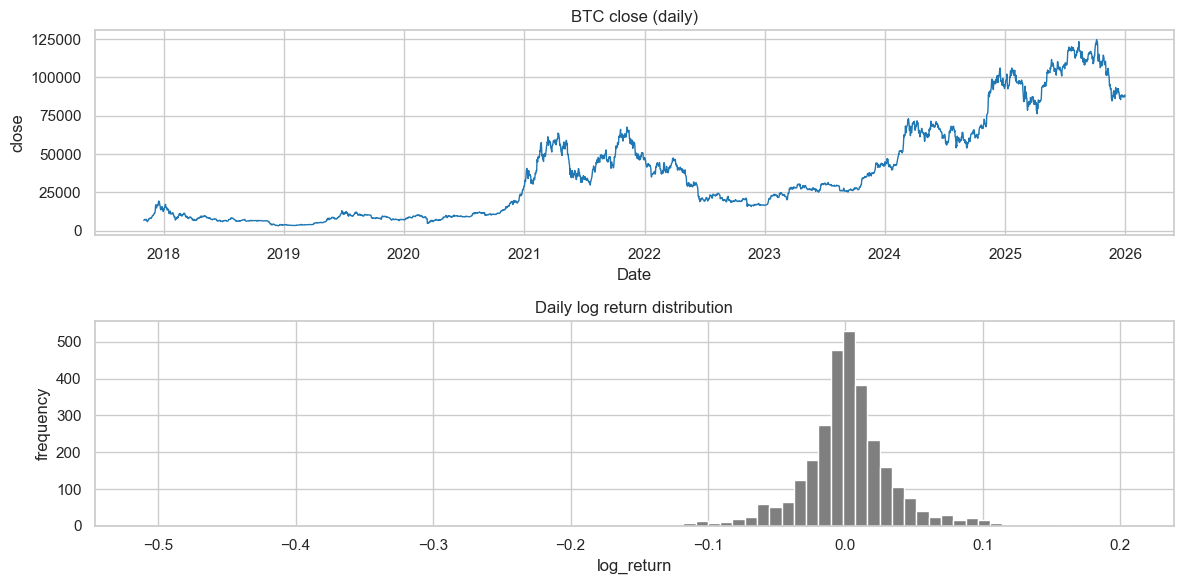


[CELL] Cell 5
Purpose: Quick look at price and daily change distribution
Notes:
- Market dataframe is the price source for labels/plots.
Variables used in this cell:
  PLOT_PRICE_MODE = 'raw'
  ax = ndarray shape=(2,) dtype=object sample=[<Axes: title={'center': 'BTC close (daily)'}, xlabel='Date', ylabel='close'>
 <Axes: title={'center': 'Daily log return distribution'}, xlabel='log_return', ylabel='frequency'>]
  df_market (market DataFrame (daily OHLCV)) = DataFrame shape=(2983, 2) cols_count=2 cols_preview=['date', 'close'] head=
        date   close
0 2017-11-01  6737.8
1 2017-11-02  7024.8
2 2017-11-03  7152.1
  log_ret = Series len=2982 name=close head=[0.041713282918156125, 0.017959274812724857, 0.029170083973008687]
  np = <module numpy>
  plt = <module matplotlib.pyplot>
  price_label = 'close'
  price_series = Series len=2983 name=close head=[6737.8, 7024.8, 7152.1]


In [4]:

# Quick look at price and daily change distribution
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

price_series = np.log(df_market['close']) if PLOT_PRICE_MODE == 'log' else df_market['close']
price_label = 'log(close)' if PLOT_PRICE_MODE == 'log' else 'close'

ax[0].plot(df_market['date'], price_series, color='tab:blue', linewidth=1)
ax[0].set_title('BTC close (daily)')
ax[0].set_xlabel('Date')
ax[0].set_ylabel(price_label)

# Log returns for a rough distribution check
log_ret = np.log(df_market['close']).diff().dropna()
ax[1].hist(log_ret, bins=80, color='tab:gray')
ax[1].set_title('Daily log return distribution')
ax[1].set_xlabel('log_return')
ax[1].set_ylabel('frequency')

plt.tight_layout()
plt.show()




trace_cell(
    title='Cell 5',
    purpose='Quick look at price and daily change distribution',
    used_vars=['PLOT_PRICE_MODE', 'ax', 'df_market', 'log_ret', 'np', 'plt', 'price_label', 'price_series'],
    notes=['Market dataframe is the price source for labels/plots.'],
    show_missing=False,
)


## 1. Oracle labels (target variable)

Idea: smooth log price, take slope, classify by threshold.


Auto threshold=63.59519440 (target_move_share=0.67)
Label params: sigma=3, threshold=63.5951943995553, horizon=1, price_mode=raw, threshold_mode=auto, target_move_share=0.67
Label mode: 3-class
MOVE share: 67.0%, SIDEWAYS share: 33.0%


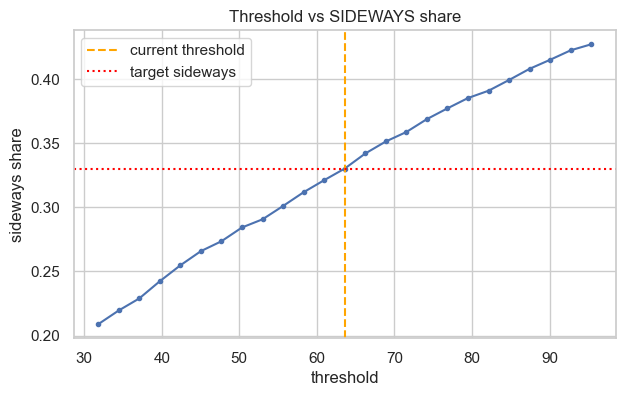

        date   close  smoothed_close  smooth_slope  target
0 2017-11-01  6737.8     6925.112641      0.000000       1
1 2017-11-02  7024.8     6985.935766     60.823125       1
2 2017-11-03  7152.1     7041.047222     55.111456       1
3 2017-11-04  7363.8     7080.257254     39.210032       1
4 2017-11-05  7389.5     7094.711820     14.454566       1

[CELL] Cell 7
Notes:
- Market dataframe is the price source for labels/plots.
- Oracle labels (targets) for training/eval.
Variables used in this cell:
  BINARY_FALLBACK = 'up'
  BINARY_TREND = False
  HORIZON = 1
  NB_THRESHOLD = None
  NB_THRESHOLD_MODE = None
  PLOT_THRESHOLD_SWEEP = True
  PRICE_MODE = 'raw'
  SIDEWAYS_SHARE_TARGET = 0.33
  SIGMA = 3
  SWEEP_FACTOR = 0.5
  SWEEP_STEPS = 25
  TARGET_MOVE_SHARE = 0.6699999999999999
  THRESHOLD = 63.5951943995553
  THRESHOLD_MAX = None
  THRESHOLD_MIN = 0.0
  THRESHOLD_MODE = 'auto'
  cfg_labels (labels config loaded from configs/labels.yaml) = dict keys_count=1 keys_preview=['labels']


In [5]:

from src.labeling.oracle import (
    create_oracle_labels,
    analyze_label_distribution,
    estimate_threshold_for_move_balance,
)

labels_cfg = cfg_labels["labels"]
SIGMA = int(labels_cfg.get("sigma", 3))
THRESHOLD = float(labels_cfg.get("threshold", 0.0005))
THRESHOLD_MODE = str(labels_cfg.get("threshold_mode", "fixed")).strip().lower()
TARGET_MOVE_SHARE = float(labels_cfg.get("target_move_share", 0.5))
THRESHOLD_MIN = labels_cfg.get("threshold_min", 0.0)
if THRESHOLD_MIN is None:
    THRESHOLD_MIN = 0.0
THRESHOLD_MIN = float(THRESHOLD_MIN)
THRESHOLD_MAX = labels_cfg.get("threshold_max", None)
if THRESHOLD_MAX is not None:
    THRESHOLD_MAX = float(THRESHOLD_MAX)
HORIZON = int(labels_cfg.get("horizon", 1))
PRICE_MODE = str(labels_cfg.get("price_mode", "log")).lower()
AUTO_GRID_SELECT = bool(labels_cfg.get("auto_grid_select", True))
BINARY_TREND = bool(labels_cfg.get("binary_trend", False))
BINARY_FALLBACK = str(labels_cfg.get("binary_fallback", "up"))

# Notebook overrides (optional)
# SIDEWAYS share + MOVE share = 1.0, so MOVE share = 1 - SIDEWAYS.
SIDEWAYS_SHARE_TARGET = 0.33  # set to None to use config target_move_share
NB_THRESHOLD = None  # set float to force fixed threshold
NB_THRESHOLD_MODE = None  # "auto" or "fixed" to override config

if NB_THRESHOLD_MODE is not None:
    THRESHOLD_MODE = str(NB_THRESHOLD_MODE).strip().lower()
if SIDEWAYS_SHARE_TARGET is not None:
    TARGET_MOVE_SHARE = 1.0 - float(SIDEWAYS_SHARE_TARGET)
if NB_THRESHOLD is not None:
    THRESHOLD = float(NB_THRESHOLD)
    THRESHOLD_MODE = "fixed"

if THRESHOLD_MODE == "auto":
    THRESHOLD = estimate_threshold_for_move_balance(
        df_market,
        sigma=SIGMA,
        price_col="close",
        price_mode=PRICE_MODE,
        target_move_share=TARGET_MOVE_SHARE,
        min_threshold=THRESHOLD_MIN,
        max_threshold=THRESHOLD_MAX,
    )
    print(f"Auto threshold={THRESHOLD:.8f} (target_move_share={TARGET_MOVE_SHARE:.2f})")

print(
    f"Label params: sigma={SIGMA}, threshold={THRESHOLD}, "
    f"horizon={HORIZON}, price_mode={PRICE_MODE}, threshold_mode={THRESHOLD_MODE}, "
    f"target_move_share={TARGET_MOVE_SHARE:.2f}"
)
print(f"Label mode: {'binary' if BINARY_TREND else '3-class'}")

df_labels = create_oracle_labels(
    df_market,
    sigma=SIGMA,
    threshold=THRESHOLD,
    price_col="close",
    price_mode=PRICE_MODE,
    binary_trend=BINARY_TREND,
    binary_fallback=BINARY_FALLBACK,
)

label_3_col = "target_3" if BINARY_TREND else "target"
move_share = (df_labels[label_3_col] != 1).mean()
sideways_share = (df_labels[label_3_col] == 1).mean()
print(f"MOVE share: {move_share*100:.1f}%, SIDEWAYS share: {sideways_share*100:.1f}%")

# Quick visual: threshold -> SIDEWAYS share
PLOT_THRESHOLD_SWEEP = True
SWEEP_STEPS = 25
SWEEP_FACTOR = 0.5  # +/-50% around current threshold
if PLOT_THRESHOLD_SWEEP:
    thr_min = max(THRESHOLD * (1.0 - SWEEP_FACTOR), 1e-10)
    thr_max = THRESHOLD * (1.0 + SWEEP_FACTOR) if THRESHOLD > 0 else 1e-3
    thresholds = np.linspace(thr_min, thr_max, SWEEP_STEPS)
    sideways_vals = []
    for t in thresholds:
        tmp = create_oracle_labels(
            df_market,
            sigma=SIGMA,
            threshold=float(t),
            price_col="close",
            price_mode=PRICE_MODE,
            binary_trend=BINARY_TREND,
            binary_fallback=BINARY_FALLBACK,
        )
        tmp_label_col = "target_3" if BINARY_TREND else "target"
        sideways_vals.append((tmp[tmp_label_col] == 1).mean())

    target_sideways = (
        float(SIDEWAYS_SHARE_TARGET)
        if SIDEWAYS_SHARE_TARGET is not None
        else 1.0 - float(TARGET_MOVE_SHARE)
    )

    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, sideways_vals, marker=".")
    plt.axvline(THRESHOLD, color="orange", linestyle="--", label="current threshold")
    if target_sideways is not None:
        plt.axhline(target_sideways, color="red", linestyle=":", label="target sideways")
    plt.title("Threshold vs SIDEWAYS share")
    plt.xlabel("threshold")
    plt.ylabel("sideways share")
    plt.legend()
    plt.show()

cols = ["date", "close", "smoothed_close", "smooth_slope", "target"]
if BINARY_TREND:
    cols.append("target_3")
print(df_labels[cols].head())




trace_cell(
    title='Cell 7',
    used_vars=['BINARY_FALLBACK', 'BINARY_TREND', 'HORIZON', 'NB_THRESHOLD', 'NB_THRESHOLD_MODE', 'PLOT_THRESHOLD_SWEEP', 'PRICE_MODE', 'SIDEWAYS_SHARE_TARGET', 'SIGMA', 'SWEEP_FACTOR', 'SWEEP_STEPS', 'TARGET_MOVE_SHARE', 'THRESHOLD', 'THRESHOLD_MAX', 'THRESHOLD_MIN', 'THRESHOLD_MODE', 'cfg_labels', 'cols', 'create_oracle_labels', 'df_labels', 'df_market', 'estimate_threshold_for_move_balance', 'label_3_col', 'labels_cfg', 'move_share', 'np', 'plt', 'sideways_share', 'sideways_vals', 't', 'target_sideways', 'thr_max', 'thr_min', 'thresholds', 'tmp', 'tmp_label_col'],
    notes=['Market dataframe is the price source for labels/plots.', 'Oracle labels (targets) for training/eval.'],
    show_missing=False,
)


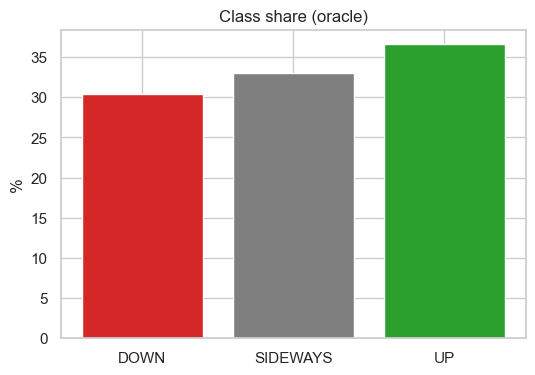


[CELL] Cell 8
Purpose: Class distribution
Notes:
- Oracle labels (targets) for training/eval.
Variables used in this cell:
  BINARY_TREND = False
  colors = list len=3 sample=['#d62728', '#7f7f7f', '#2ca02c']
  counts = Series len=3 name=proportion head=[30.372108615487765, 33.02044921220248, 36.60744217230976]
  df_labels (oracle labels table) = DataFrame shape=(2983, 5) cols_count=5 cols_preview=['date', 'close', 'smoothed_close', 'smooth_slope', 'target'] head=
        date   close  smoothed_close  smooth_slope  target
0 2017-11-01  6737.8     6925.112641      0.000000       1
1 2017-11-02  7024.8     6985.935766     60.823125       1
2 2017-11-03  7152.1     7041.047222     55.111456       1
  label_map = dict keys_count=3 keys_preview=[0, 1, 2]
  plt = <module matplotlib.pyplot>


In [6]:

# Class distribution
if BINARY_TREND:
    label_map = {0: "DOWN", 1: "UP"}
    counts = df_labels["target"].value_counts(normalize=True).sort_index() * 100
    colors = ["#d62728", "#2ca02c"]
else:
    label_map = {0: "DOWN", 1: "SIDEWAYS", 2: "UP"}
    counts = df_labels["target"].value_counts(normalize=True).sort_index() * 100
    colors = ["#d62728", "#7f7f7f", "#2ca02c"]

plt.figure(figsize=(6, 4))
plt.bar([label_map[i] for i in counts.index], counts.values, color=colors)
plt.title("Class share (oracle)")
plt.ylabel("%")
plt.show()




trace_cell(
    title='Cell 8',
    purpose='Class distribution',
    used_vars=['BINARY_TREND', 'colors', 'counts', 'df_labels', 'i', 'label_map', 'plt'],
    notes=['Oracle labels (targets) for training/eval.'],
    show_missing=False,
)


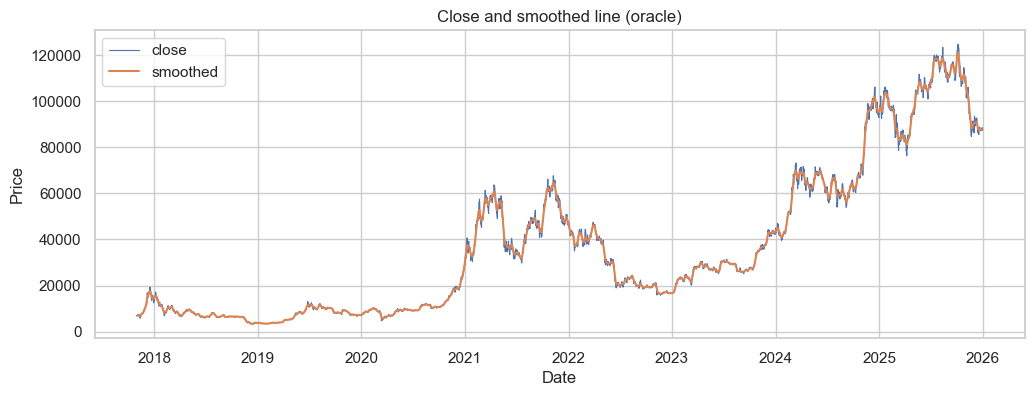


[CELL] Cell 9
Purpose: Visual: price vs smoothed price
Notes:
- Oracle labels (targets) for training/eval.
Variables used in this cell:
  PLOT_PRICE_MODE = 'raw'
  ax = <Axes: title={'center': 'Close and smoothed line (oracle)'}, xlabel='Date', ylabel='Price'>
  close_series = Series len=2983 name=close head=[6737.8, 7024.8, 7152.1]
  df_labels (oracle labels table) = DataFrame shape=(2983, 5) cols_count=5 cols_preview=['date', 'close', 'smoothed_close', 'smooth_slope', 'target'] head=
        date   close  smoothed_close  smooth_slope  target
0 2017-11-01  6737.8     6925.112641      0.000000       1
1 2017-11-02  7024.8     6985.935766     60.823125       1
2 2017-11-03  7152.1     7041.047222     55.111456       1
  np = <module numpy>
  plt = <module matplotlib.pyplot>
  smoothed_series = Series len=2983 name=smoothed_close head=[6925.112640894508, 6985.93576551112, 7041.04722195844]
  title = 'Close and smoothed line (oracle)'
  ylabel = 'Price'


In [7]:

# Visual: price vs smoothed price
if PLOT_PRICE_MODE == 'log':
    close_series = np.log(df_labels['close'])
    smoothed_series = np.log(df_labels['smoothed_close'])
    ylabel = 'log(price)'
    title = 'Log close and log-smoothed line (oracle)'
else:
    close_series = df_labels['close']
    smoothed_series = df_labels['smoothed_close']
    ylabel = 'Price'
    title = 'Close and smoothed line (oracle)'

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df_labels['date'], close_series, label='close', linewidth=0.8)
ax.plot(df_labels['date'], smoothed_series, label='smoothed', linewidth=1.5)
ax.set_title(title)
ax.set_xlabel('Date')
ax.set_ylabel(ylabel)
ax.legend()
plt.show()




trace_cell(
    title='Cell 9',
    purpose='Visual: price vs smoothed price',
    used_vars=['PLOT_PRICE_MODE', 'ax', 'close_series', 'df_labels', 'np', 'plt', 'smoothed_series', 'title', 'ylabel'],
    notes=['Oracle labels (targets) for training/eval.'],
    show_missing=False,
)


In [8]:

# Auto-tune sigma/threshold (minimize DOWN vs UP imbalance)
# Also support auto-threshold (move share target)

if AUTO_GRID_SELECT:
    sigma_min = max(2, SIGMA - 2)
    sigma_max = SIGMA + 2

    if THRESHOLD_MODE == "auto":
        sigmas = np.unique(np.linspace(sigma_min, sigma_max, 5, dtype=int))
        rows = []
        for s in sigmas:
            thr = estimate_threshold_for_move_balance(
                df_market,
                sigma=int(s),
                price_col="close",
                price_mode=PRICE_MODE,
                target_move_share=TARGET_MOVE_SHARE,
                min_threshold=THRESHOLD_MIN,
                max_threshold=THRESHOLD_MAX,
            )
            labeled = create_oracle_labels(
                df_market,
                sigma=int(s),
                threshold=float(thr),
                price_col="close",
                price_mode=PRICE_MODE,
                binary_trend=BINARY_TREND,
                binary_fallback=BINARY_FALLBACK,
            )
            label_col = "target_3" if BINARY_TREND else "target"
            counts = labeled[label_col].value_counts(normalize=True)
            rows.append({
                "sigma": int(s),
                "threshold": float(thr),
                "down_pct": counts.get(0, 0) * 100,
                "sideways_pct": counts.get(1, 0) * 100,
                "up_pct": counts.get(2, 0) * 100,
                "imbalance": abs(counts.get(0, 0) - counts.get(2, 0)) * 100,
            })
        grid = pd.DataFrame(rows).sort_values("imbalance")
    else:
        thr_min = max(THRESHOLD * 0.5, 1e-6)
        thr_max = THRESHOLD * 1.5 if THRESHOLD > 0 else 1e-3
        grid = analyze_label_distribution(
            df_market,
            sigma_range=(sigma_min, sigma_max),
            threshold_range=(thr_min, thr_max),
            n_steps=5,
            price_mode=PRICE_MODE,
            price_col="close",
        )

    best = grid.iloc[0]
    SIGMA = int(best["sigma"])
    THRESHOLD = float(best["threshold"])
    print(f"Auto-grid: sigma={SIGMA}, threshold={THRESHOLD:.8f} (imbalance={best['imbalance']:.2f}%)")

    df_labels = create_oracle_labels(
        df_market,
        sigma=SIGMA,
        threshold=THRESHOLD,
        price_col="close",
        price_mode=PRICE_MODE,
        binary_trend=BINARY_TREND,
        binary_fallback=BINARY_FALLBACK,
    )




trace_cell(
    title='Cell 10',
    purpose='Auto-tune sigma/threshold (minimize DOWN vs UP imbalance)',
    used_vars=['AUTO_GRID_SELECT', 'BINARY_FALLBACK', 'BINARY_TREND', 'PRICE_MODE', 'SIGMA', 'TARGET_MOVE_SHARE', 'THRESHOLD', 'THRESHOLD_MAX', 'THRESHOLD_MIN', 'THRESHOLD_MODE', 'analyze_label_distribution', 'best', 'counts', 'create_oracle_labels', 'df_market', 'estimate_threshold_for_move_balance', 'grid', 'label_col', 'labeled', 'np', 'pd', 'rows', 's', 'sigma_max', 'sigma_min', 'sigmas', 'thr', 'thr_max', 'thr_min'],
    notes=['Market dataframe is the price source for labels/plots.'],
    show_missing=False,
)


Auto-grid: sigma=5, threshold=53.58359715 (imbalance=4.96%)

[CELL] Cell 10
Purpose: Auto-tune sigma/threshold (minimize DOWN vs UP imbalance)
Notes:
- Market dataframe is the price source for labels/plots.
Variables used in this cell:
  AUTO_GRID_SELECT = True
  BINARY_FALLBACK = 'up'
  BINARY_TREND = False
  PRICE_MODE = 'raw'
  SIGMA = 5
  TARGET_MOVE_SHARE = 0.6699999999999999
  THRESHOLD = 53.58359714921031
  THRESHOLD_MAX = None
  THRESHOLD_MIN = 0.0
  THRESHOLD_MODE = 'auto'
  analyze_label_distribution = <function analyze_label_distribution>
  best = Series len=6 name=3 head=[5.0, 53.58359714921031, 31.009051290647]
  counts = Series len=3 name=proportion head=[0.3597049949715052, 0.3302044921220248, 0.31009051290647]
  create_oracle_labels = <function create_oracle_labels>
  df_market (market DataFrame (daily OHLCV)) = DataFrame shape=(2983, 2) cols_count=2 cols_preview=['date', 'close'] head=
        date   close
0 2017-11-01  6737.8
1 2017-11-02  7024.8
2 2017-11-03  7152.1


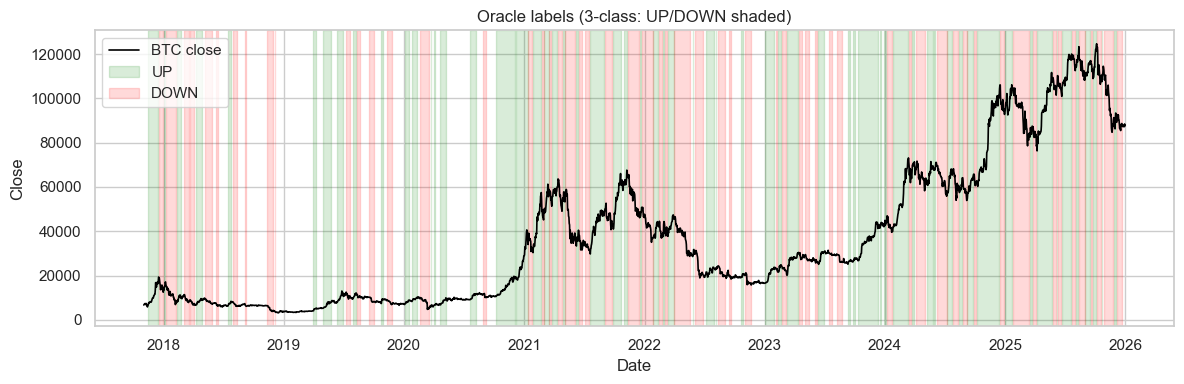


[CELL] Cell 11
Purpose: Simple oracle label plot (matplotlib)
Notes:
- Oracle labels (targets) for training/eval.
Variables used in this cell:
  BINARY_TREND = False
  PLOT_PRICE_MODE = 'raw'
  ax = <Axes: title={'center': 'Oracle labels (3-class: UP/DOWN shaded)'}, xlabel='Date', ylabel='Close'>
  close = ndarray shape=(2983,) dtype=float64 sample=[6737.8 7024.8 7152.1 7363.8 7389.5]
  dates = ndarray shape=(2983,) dtype=datetime64[ns] sample=['2017-11-01T00:00:00.000000000' '2017-11-02T00:00:00.000000000'
 '2017-11-03T00:00:00.000000000' '2017-11-04T00:00:00.000000000'
 '2017-11-05T00:00:00.000000000']
  df_labels (oracle labels table) = DataFrame shape=(2983, 5) cols_count=5 cols_preview=['date', 'close', 'smoothed_close', 'smooth_slope', 'target'] head=
        date   close  smoothed_close  smooth_slope  target
0 2017-11-01  6737.8     6913.381148      0.000000       1
1 2017-11-02  7024.8     6935.999927     22.618779       1
2 2017-11-03  7152.1     6953.912465     17.912539    

In [9]:

# Simple oracle label plot (matplotlib)
plot_df = df_labels[['date', 'close', 'target']].copy()
plot_df['date'] = pd.to_datetime(plot_df['date'])
plot_df = plot_df.sort_values('date').reset_index(drop=True)

def shade_up_down(ax, dates, close, up_mask, down_mask, title: str, y_label: str):
    ax.plot(dates, close, color='black', linewidth=1.2, label='BTC close')
    ax.fill_between(
        dates,
        0,
        1,
        where=up_mask,
        transform=ax.get_xaxis_transform(),
        color='green',
        alpha=0.15,
        label='UP',
    )
    ax.fill_between(
        dates,
        0,
        1,
        where=down_mask,
        transform=ax.get_xaxis_transform(),
        color='red',
        alpha=0.15,
        label='DOWN',
    )
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.legend(loc='upper left')

labels = plot_df['target'].to_numpy()
if BINARY_TREND:
    up_mask = labels == 1
    down_mask = labels == 0
    title = 'Oracle labels (binary: UP/DOWN)'
else:
    up_mask = labels == 2
    down_mask = labels == 0
    title = 'Oracle labels (3-class: UP/DOWN shaded)'

dates = plot_df['date'].to_numpy()
if PLOT_PRICE_MODE == 'log':
    close = np.log(plot_df['close'].to_numpy())
    y_label = 'log(price)'
else:
    close = plot_df['close'].to_numpy()
    y_label = 'Close'

fig, ax = plt.subplots(figsize=(12, 4))
shade_up_down(ax, dates, close, up_mask, down_mask, title, y_label)
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()




trace_cell(
    title='Cell 11',
    purpose='Simple oracle label plot (matplotlib)',
    used_vars=['BINARY_TREND', 'PLOT_PRICE_MODE', 'ax', 'close', 'dates', 'df_labels', 'down_mask', 'labels', 'np', 'pd', 'plot_df', 'plt', 'shade_up_down', 'title', 'up_mask', 'y_label'],
    notes=['Oracle labels (targets) for training/eval.'],
    show_missing=False,
)


## 2. Target shift by horizon


In [10]:

# Shift target to the future (features(t) -> target(t+horizon))
df_labels_shifted = df_labels.copy()
df_labels_shifted["target"] = df_labels_shifted["target"].shift(-HORIZON)

# Drop rows without future label
df_labels_shifted = df_labels_shifted.dropna(subset=["target"]).reset_index(drop=True)
df_labels_shifted["target"] = df_labels_shifted["target"].astype(int)

print(df_labels_shifted[["date", "target"]].tail())
print(f"Rows after shift: {len(df_labels_shifted)}")




trace_cell(
    title='Cell 13',
    purpose='Shift target to the future (features(t) -> target(t+horizon))',
    used_vars=['HORIZON', 'df_labels', 'df_labels_shifted'],
    notes=['Oracle labels (targets) for training/eval.'],
    show_missing=False,
)


           date  target
2977 2025-12-26       1
2978 2025-12-27       1
2979 2025-12-28       1
2980 2025-12-29       1
2981 2025-12-30       1
Rows after shift: 2982

[CELL] Cell 13
Purpose: Shift target to the future (features(t) -> target(t+horizon))
Notes:
- Oracle labels (targets) for training/eval.
Variables used in this cell:
  HORIZON = 1
  df_labels (oracle labels table) = DataFrame shape=(2983, 5) cols_count=5 cols_preview=['date', 'close', 'smoothed_close', 'smooth_slope', 'target'] head=
        date   close  smoothed_close  smooth_slope  target
0 2017-11-01  6737.8     6913.381148      0.000000       1
1 2017-11-02  7024.8     6935.999927     22.618779       1
2 2017-11-03  7152.1     6953.912465     17.912539       1
  df_labels_shifted = DataFrame shape=(2982, 5) cols_count=5 cols_preview=['date', 'close', 'smoothed_close', 'smooth_slope', 'target'] head=
        date   close  smoothed_close  smooth_slope  target
0 2017-11-01  6737.8     6913.381148      0.000000       1

## 3. Astro data and astro features


In [11]:
from datetime import datetime, timezone
from tqdm import tqdm

from src.astro.engine.settings import AstroSettings
from src.astro.engine.calculator import set_ephe_path, calculate_daily_bodies, calculate_bodies
from src.astro.engine.aspects import calculate_aspects, calculate_transit_aspects
from src.astro.engine.models import AspectConfig
from src.features.builder import build_features_daily


def _parse_birth_dt_utc(value: str) -> datetime:
    s = value.strip()
    if s.endswith('Z'):
        s = s[:-1] + '+00:00'
    dt = datetime.fromisoformat(s)
    if dt.tzinfo is None:
        dt = dt.replace(tzinfo=timezone.utc)
    return dt.astimezone(timezone.utc)


# Astro settings
astro_cfg = cfg_astro["astro"]
# Same path rules: resolve to PROJECT_ROOT
_ephe_path = _resolve_path(astro_cfg["ephe_path"])
set_ephe_path(str(_ephe_path))

settings = AstroSettings(
    bodies_path=_resolve_path(astro_cfg["bodies_path"]),
    aspects_path=_resolve_path(astro_cfg["aspects_path"]),
)

time_utc = datetime.strptime(astro_cfg["daily_time_utc"], "%H:%M:%S").time()
center = astro_cfg.get("center", "geo")

include_pair_aspects = bool(astro_cfg.get("include_pair_aspects", True))
include_transit_aspects = bool(astro_cfg.get("include_transit_aspects", False))

bodies_path = processed_dir / f"{subject.subject_id}_astro_bodies.parquet"
aspects_path = processed_dir / f"{subject.subject_id}_astro_aspects.parquet"
transits_path = processed_dir / f"{subject.subject_id}_transit_aspects.parquet"
features_path = processed_dir / f"{subject.subject_id}_features.parquet"

# Orb multiplier (1.0 = default orbs from aspects.yaml)
ORB_MULTIPLIER = 1.0

natal_bodies = None
if include_transit_aspects:
    birth_dt = _parse_birth_dt_utc(subject.birth_dt_utc)
    natal_bodies = calculate_bodies(birth_dt, settings.bodies, center=center)

# Ignore astro cache, recompute
print("Ignoring astro cache, recomputing bodies...")
bodies_rows = []
bodies_by_date = {}
dates = pd.to_datetime(df_market["date"]).dt.date

for d in tqdm(dates, desc="astro days"):
    bodies = calculate_daily_bodies(d, time_utc, settings.bodies, center=center)
    bodies_by_date[d] = bodies

    for b in bodies:
        bodies_rows.append({
            "date": b.date,
            "body": b.body,
            "lon": b.lon,
            "lat": b.lat,
            "speed": b.speed,
            "is_retro": b.is_retro,
            "sign": b.sign,
            "declination": b.declination,
        })

df_bodies = pd.DataFrame(bodies_rows)


def _scale_aspects(aspects, orb_mult: float):
    scaled = []
    for a in aspects:
        scaled.append(AspectConfig(name=a.name, degree=a.degree, orb=float(a.orb) * float(orb_mult)))
    return scaled


def build_aspects_df_for_orb(orb_mult: float):
    aspects_rows = []
    aspects_cfg = _scale_aspects(settings.aspects, orb_mult)
    for d, bodies in bodies_by_date.items():
        aspects = calculate_aspects(bodies, aspects_cfg)
        for a in aspects:
            aspects_rows.append({
                "date": a.date,
                "p1": a.p1,
                "p2": a.p2,
                "aspect": a.aspect,
                "orb": a.orb,
                "is_exact": a.is_exact,
                "is_applying": a.is_applying,
            })
    return pd.DataFrame(aspects_rows)


if include_pair_aspects:
    print(f"Computing aspects with ORB_MULTIPLIER={ORB_MULTIPLIER}")
    df_aspects = build_aspects_df_for_orb(ORB_MULTIPLIER)
else:
    print("Skipping transit-transit aspects (include_pair_aspects=False)")
    df_aspects = pd.DataFrame(columns=["date", "p1", "p2", "aspect", "orb", "is_exact", "is_applying"])

# Transit->natal aspects (optional)
df_transits = None
if include_transit_aspects:
    print(f"Computing transit->natal aspects with ORB_MULTIPLIER={ORB_MULTIPLIER}")
    transit_rows = []
    aspects_cfg = _scale_aspects(settings.aspects, ORB_MULTIPLIER)
    for d, bodies in bodies_by_date.items():
        hits = calculate_transit_aspects(bodies, natal_bodies, aspects_cfg)
        for h in hits:
            transit_rows.append({
                "date": h.date,
                "transit_body": h.transit_body,
                "natal_body": h.natal_body,
                "aspect": h.aspect,
                "orb": h.orb,
                "is_exact": h.is_exact,
                "is_applying": h.is_applying,
            })
    df_transits = pd.DataFrame(transit_rows)

bodies_path.parent.mkdir(parents=True, exist_ok=True)
df_bodies.to_parquet(bodies_path, index=False)
if include_pair_aspects:
    df_aspects.to_parquet(aspects_path, index=False)
if include_transit_aspects and df_transits is not None:
    df_transits.to_parquet(transits_path, index=False)

print(f"Saved bodies: {bodies_path}")
if include_pair_aspects:
    print(f"Saved aspects: {aspects_path}")
if include_transit_aspects:
    print(f"Saved transits: {transits_path}")

print(df_bodies.head())
print(df_aspects.head())
if include_transit_aspects and df_transits is not None:
    print(df_transits.head())

trace_cell(
    title='Cell 15',
    used_vars=['AstroSettings', 'ORB_MULTIPLIER', '_ephe_path', '_resolve_path', 'aspects_path', 'astro_cfg', 'b', 'bodies', 'bodies_by_date', 'bodies_path', 'bodies_rows', 'build_aspects_df_for_orb', 'calculate_daily_bodies', 'calculate_bodies', 'calculate_aspects', 'calculate_transit_aspects', 'center', 'cfg_astro', 'd', 'dates', 'datetime', 'df_aspects', 'df_bodies', 'df_market', 'df_transits', 'include_pair_aspects', 'include_transit_aspects', 'pd', 'processed_dir', 'set_ephe_path', 'settings', 'subject', 'time_utc', 'tqdm'],
    notes=['Uses astro config (bodies/aspects paths, ephemeris path, center).', 'Center controls geo vs helio coordinates for astro bodies/aspects.', 'Market dataframe is the price source for labels/plots.'],
    show_missing=False,
)



Ignoring astro cache, recomputing...


astro days: 100%|███████████████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 5053.26it/s]


Saved bodies: C:\_PYTH\projects\PythonProject\ostrofun\data\market\processed\btc_astro_bodies.parquet
Saved aspects: C:\_PYTH\projects\PythonProject\ostrofun\data\market\processed\btc_astro_aspects.parquet
         date     body         lon       lat      speed  is_retro     sign  declination
0  2017-11-01      Sun  218.755657 -0.000011   1.000008     False  Scorpio    -0.000011
1  2017-11-01     Moon  356.209228 -2.907350  13.493332     False   Pisces    -2.907350
2  2017-11-01  Mercury  232.905646 -1.409936   1.497015     False  Scorpio    -1.409936
3  2017-11-01    Venus  201.888931  1.488282   1.249436     False    Libra     1.488282
4  2017-11-01     Mars  185.828074  1.137132   0.631064     False    Libra     1.137132
         date    p1       p2       aspect       orb  is_exact  is_applying
0  2017-11-01   Sun  Jupiter  Conjunction  4.092977     False        False
1  2017-11-01   Sun  Neptune        Trine  2.840517     False         True
2  2017-11-01  Moon  Mercury        Trine

In [12]:
# Build astro features
# Ignore features cache, recompute
print("Ignoring features cache, recomputing...")
df_features = build_features_daily(
    df_bodies,
    df_aspects,
    df_transits if include_transit_aspects else None,
    include_pair_aspects=include_pair_aspects,
    include_transit_aspects=include_transit_aspects,
)
df_features.to_parquet(features_path, index=False)
print(f"Saved features: {features_path}")

print(df_features.head())
print(f"Features: {df_features.shape}")




trace_cell(
    title='Cell 16',
    purpose='Build astro features',
    used_vars=['build_features_daily', 'df_aspects', 'df_bodies', 'df_features', 'df_transits', 'features_path', 'include_pair_aspects', 'include_transit_aspects'],
    notes=['Feature matrix used for XGBoost training.'],
    show_missing=False,
)



Ignoring features cache, recomputing...
Saved features: C:\_PYTH\projects\PythonProject\ostrofun\data\market\processed\btc_features.parquet
         date  Jupiter_lon  Lilith_lon    Mars_lon  MeanNode_lon  Mercury_lon    Moon_lon  Neptune_lon   Pluto_lon  Saturn_lon     Sun_lon  TrueNode_lon  Uranus_lon   Venus_lon  Jupiter_speed  \
0  2017-11-01   214.662680  269.089371  185.828074    140.126691   232.905646  356.209228   341.596174  287.127692  264.609855  218.755657    141.000541   26.027296  201.888931       0.218073   
1  2017-11-02   214.880702  269.200882  186.459109    140.073706   234.398481    9.936665   341.584602  287.144191  264.703843  219.755898    140.886151   25.987864  203.138561       0.217967   
2  2017-11-03   215.098611  269.312392  187.090093    140.020725   235.882907   24.114155   341.573540  287.161145  264.798752  220.756617    140.729548   25.948669  204.388586       0.217850   
3  2017-11-04   215.316399  269.423908  187.721044    139.967753   237.358797   

## 4. Merge features and target


In [13]:

# Merge by date
features = df_features.copy()
features["date"] = pd.to_datetime(features["date"])

labels = df_labels_shifted[["date", "target"]].copy()
labels["date"] = pd.to_datetime(labels["date"])

# Date intersection only
df_dataset = pd.merge(features, labels, on="date", how="inner")

# Drop possible duplicates
if df_dataset["date"].duplicated().any():
    df_dataset = df_dataset.drop_duplicates(subset=["date"]).reset_index(drop=True)

print(df_dataset.head())
print(f"Final dataset: {df_dataset.shape}")




trace_cell(
    title='Cell 18',
    purpose='Merge by date',
    used_vars=['df_dataset', 'df_features', 'df_labels_shifted', 'features', 'labels', 'pd'],
    notes=['Feature matrix used for XGBoost training.'],
    show_missing=False,
)


        date  Jupiter_lon  Lilith_lon    Mars_lon  MeanNode_lon  Mercury_lon    Moon_lon  Neptune_lon   Pluto_lon  Saturn_lon     Sun_lon  TrueNode_lon  Uranus_lon   Venus_lon  Jupiter_speed  \
0 2017-11-01   214.662680  269.089371  185.828074    140.126691   232.905646  356.209228   341.596174  287.127692  264.609855  218.755657    141.000541   26.027296  201.888931       0.218073   
1 2017-11-02   214.880702  269.200882  186.459109    140.073706   234.398481    9.936665   341.584602  287.144191  264.703843  219.755898    140.886151   25.987864  203.138561       0.217967   
2 2017-11-03   215.098611  269.312392  187.090093    140.020725   235.882907   24.114155   341.573540  287.161145  264.798752  220.756617    140.729548   25.948669  204.388586       0.217850   
3 2017-11-04   215.316399  269.423908  187.721044    139.967753   237.358797   38.675453   341.562998  287.178557  264.894571  221.757832    140.543240   25.909734  205.639012       0.217722   
4 2017-11-05   215.534050  269

## 5. Train/val/test split (time-based)


In [14]:

# Time-based split without shuffling
train_ratio = 0.7
val_ratio = 0.15

n = len(df_dataset)
train_end = int(n * train_ratio)
val_end = int(n * (train_ratio + val_ratio))

train_df = df_dataset.iloc[:train_end].copy()
val_df = df_dataset.iloc[train_end:val_end].copy()
test_df = df_dataset.iloc[val_end:].copy()

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"Train range: {train_df['date'].min().date()} -> {train_df['date'].max().date()}")
print(f"Test range : {test_df['date'].min().date()} -> {test_df['date'].max().date()}")




trace_cell(
    title='Cell 20',
    purpose='Time-based split without shuffling',
    used_vars=['df_dataset', 'n', 'test_df', 'train_df', 'train_end', 'train_ratio', 'val_df', 'val_end', 'val_ratio'],
    show_missing=False,
)


Train: 2087 | Val: 447 | Test: 448
Train range: 2017-11-01 -> 2023-07-19
Test range : 2024-10-09 -> 2025-12-30

[CELL] Cell 20
Purpose: Time-based split without shuffling
Variables used in this cell:
  df_dataset = DataFrame shape=(2982, 749) cols_count=749 cols_preview=['date', 'Jupiter_lon', 'Lilith_lon', 'Mars_lon', 'MeanNode_lon', 'Mercury_lon', 'Moon_lon', 'Neptune_lon', 'Pluto_lon', 'Saturn_lon', 'Sun_lon', 'TrueNode_lon', 'Uranus_lon', 'Venus_lon', 'Jupiter_speed', 'Lilith_speed', 'Mars_speed', 'MeanNode_speed', 'Mercury_speed', 'Moon_speed', 'Neptune_speed', 'Pluto_speed', 'Saturn_speed', 'Sun_speed', 'TrueNode_speed'] head=
        date  Jupiter_lon  Lilith_lon    Mars_lon  MeanNode_lon  Mercury_lon    Moon_lon  Neptune_lon   Pluto_lon  Saturn_lon     Sun_lon  TrueNode_lon  Uranus_lon   Venus_lon  Jupiter_speed  \
0 2017-11-01   214.662680  269.089371  185.828074    140.126691   232.905646  356.209228   341.596174  287.127692  264.609855  218.755657    141.000541   26.027296  

## 6. Prepare X/y matrices


In [15]:

# Feature list (astro only)
feature_cols = [c for c in df_dataset.columns if c not in ["date", "target"]]

X_train = train_df[feature_cols].to_numpy(dtype=np.float64)
y_train = train_df["target"].to_numpy(dtype=np.int32)

X_val = val_df[feature_cols].to_numpy(dtype=np.float64)
y_val = val_df["target"].to_numpy(dtype=np.int32)

X_test = test_df[feature_cols].to_numpy(dtype=np.float64)
y_test = test_df["target"].to_numpy(dtype=np.int32)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val  : {X_val.shape}, y_val  : {y_val.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")




trace_cell(
    title='Cell 22',
    purpose='Feature list (astro only)',
    used_vars=['X_test', 'X_train', 'X_val', 'c', 'df_dataset', 'feature_cols', 'np', 'test_df', 'train_df', 'val_df', 'y_test', 'y_train', 'y_val'],
    show_missing=False,
)


X_train: (2087, 747), y_train: (2087,)
X_val  : (447, 747), y_val  : (447,)
X_test : (448, 747), y_test : (448,)

[CELL] Cell 22
Purpose: Feature list (astro only)
Variables used in this cell:
  X_test = ndarray shape=(448, 747) dtype=float64 sample=[ 81.33759015 191.25393206 108.91693976   5.9446794  202.14406513]
  X_train = ndarray shape=(2087, 747) dtype=float64 sample=[214.6626803  269.08937111 185.82807396 140.12669116 232.90564605]
  X_val = ndarray shape=(447, 747) dtype=float64 sample=[ 42.23336471 141.55683756 155.81484544  29.61378872 136.16549112]
  df_dataset = DataFrame shape=(2982, 749) cols_count=749 cols_preview=['date', 'Jupiter_lon', 'Lilith_lon', 'Mars_lon', 'MeanNode_lon', 'Mercury_lon', 'Moon_lon', 'Neptune_lon', 'Pluto_lon', 'Saturn_lon', 'Sun_lon', 'TrueNode_lon', 'Uranus_lon', 'Venus_lon', 'Jupiter_speed', 'Lilith_speed', 'Mars_speed', 'MeanNode_speed', 'Mercury_speed', 'Moon_speed', 'Neptune_speed', 'Pluto_speed', 'Saturn_speed', 'Sun_speed', 'TrueNode_speed']

## 7. XGBoost training


In [16]:

import xgboost as xgb
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    matthews_corrcoef,
    recall_score,
)
import sys
from pathlib import Path
# Ensure repo root is on sys.path so src/ imports work
_ROOT = Path.cwd()
if not (_ROOT / "src").exists():
    if (_ROOT.parent / "src").exists():
        _ROOT = _ROOT.parent
    elif (_ROOT.parent.parent / "src").exists():
        _ROOT = _ROOT.parent.parent
if str(_ROOT) not in sys.path:
    sys.path.insert(0, str(_ROOT))

from src.models.xgb import XGBBaseline

train_cfg = cfg_train.get("training", {})
TWO_STAGE = bool(train_cfg.get("two_stage", True))
if BINARY_TREND and TWO_STAGE:
    print("Binary trend active -> forcing SINGLE_STAGE")
    TWO_STAGE = False

# Check if this XGBoost build supports CUDA
use_cuda = False
try:
    info = xgb.build_info()
    use_cuda = bool(info.get("USE_CUDA", False))
    print(f"XGBoost build_info USE_CUDA = {info.get('USE_CUDA', None)}")
except Exception as e:
    print("Failed to read build_info:", e)

device = "cuda" if use_cuda else "cpu"
print(f"Using device={device}")

if BINARY_TREND:
    label_names = ["DOWN", "UP"]
    label_ids = [0, 1]
else:
    label_names = ["DOWN", "SIDEWAYS", "UP"]
    label_ids = [0, 1, 2]
N_CLASSES = len(label_ids)


def majority_baseline_pred(y_true, lbls):
    counts = [int((y_true == lbl).sum()) for lbl in lbls]
    majority_label = lbls[int(np.argmax(counts))]
    return np.full_like(y_true, majority_label)


def prev_label_baseline_pred(y_true, fallback_label: int = 0):
    if len(y_true) == 0:
        return np.array([], dtype=y_true.dtype)
    pred = np.roll(y_true, 1)
    pred[0] = fallback_label
    return pred


def calc_metrics(y_true, y_pred, lbls):
    acc = accuracy_score(y_true, y_pred)
    bal = recall_score(y_true, y_pred, labels=lbls, average="macro", zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return {
        "acc": acc,
        "bal_acc": bal,
        "mcc": mcc,
        "f1_macro": f1m,
        "summary": 0.5 * (bal + f1m),
    }


def bootstrap_metrics(y_true, y_pred, lbls, n_boot=200, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    if n == 0:
        return None
    samples = {"acc": [], "bal_acc": [], "mcc": [], "f1_macro": [], "summary": []}
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        m = calc_metrics(y_true[idx], y_pred[idx], lbls)
        for k in samples:
            samples[k].append(m[k])
    out = {}
    for k, vals in samples.items():
        lo, hi = np.percentile(vals, [2.5, 97.5])
        out[k] = (float(lo), float(hi))
    return out



trace_cell(
    title='Cell 24',
    used_vars=['BINARY_TREND', 'TWO_STAGE', 'cfg_train', 'device', 'e', 'info', 'label_ids', 'train_cfg', 'use_cuda', 'xgb'],
    show_missing=False,
)


XGBoost build_info USE_CUDA = True
Using device=cuda

[CELL] Cell 24
Variables used in this cell:
  BINARY_TREND = False
  TWO_STAGE (two-stage XGB (move + direction) flag) = True
  cfg_train = dict keys_count=1 keys_preview=['training']
  device = 'cuda'
  info = dict keys_count=13 keys_preview=['BUILTIN_PREFETCH_PRESENT', 'CUDA_VERSION', 'DEBUG', 'MM_PREFETCH_PRESENT', 'THRUST_VERSION']...
  label_ids = list len=3 sample=[0, 1, 2]
  train_cfg = dict keys_count=1 keys_preview=['two_stage']
  use_cuda = True
  xgb = <module xgboost>


Training mode: TWO_STAGE (MOVE/NO_MOVE -> UP/DOWN)

Overall (3-class) metrics
Accuracy: 0.18526785714285715
Balanced acc: 0.3083865177502992
MCC: -0.009809596221207487
F1 macro: 0.1842104626403407
Summary score (avg bal_acc + f1_macro): 0.24629849019531994
Class distribution: DOWN=184 (41.1%), SIDEWAYS=46 (10.3%), UP=218 (48.7%)
Classification report:
              precision    recall  f1-score   support

        DOWN       0.37      0.08      0.13       184
    SIDEWAYS       0.09      0.67      0.16        46
          UP       0.54      0.17      0.26       218

    accuracy                           0.19       448
   macro avg       0.33      0.31      0.18       448
weighted avg       0.42      0.19      0.20       448

Majority baseline -> acc=0.4866, bal_acc=0.3333, f1_macro=0.2182, summary=0.2758
Prev-label baseline -> acc=0.9040, bal_acc=0.8111, f1_macro=0.8122, summary=0.8116
Model 95% bootstrap CI:
  acc 95% CI: [0.1540, 0.2255]
  bal_acc 95% CI: [0.2509, 0.3533]
  f1_macro 

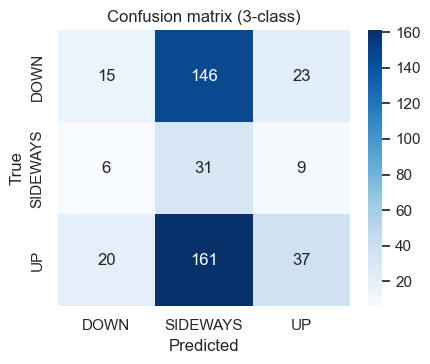


Stage 1 (MOVE vs NO_MOVE) metrics
Accuracy: 0.28125
Balanced acc: 0.4551157257192299
MCC: -0.06330841680034693
F1 macro: 0.2662760416666667
Summary score (avg bal_acc + f1_macro): 0.3606958836929483
Class distribution: NO_MOVE=46 (10.3%), MOVE=402 (89.7%)
Classification report:
              precision    recall  f1-score   support

     NO_MOVE       0.09      0.67      0.16        46
        MOVE       0.86      0.24      0.37       402

    accuracy                           0.28       448
   macro avg       0.48      0.46      0.27       448
weighted avg       0.78      0.28      0.35       448

Majority baseline -> acc=0.8973, bal_acc=0.5000, f1_macro=0.4729, summary=0.4865
Prev-label baseline -> acc=0.9062, bal_acc=0.7456, f1_macro=0.7456, summary=0.7456
Model 95% bootstrap CI:
  acc 95% CI: [0.2455, 0.3237]
  bal_acc 95% CI: [0.3751, 0.5172]
  f1_macro 95% CI: [0.2323, 0.3073]
  summary 95% CI: [0.3072, 0.4083]


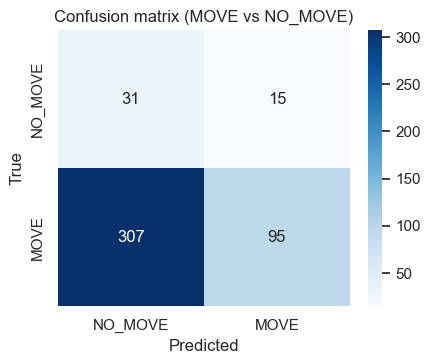


Stage 2 (UP vs DOWN) metrics
Accuracy: 0.5248756218905473
Balanced acc: 0.5237834064619067
MCC: 0.04741750881967636
F1 macro: 0.5233152258264784
Summary score (avg bal_acc + f1_macro): 0.5235493161441925
Class distribution: DOWN=184 (45.8%), UP=218 (54.2%)
Classification report:
              precision    recall  f1-score   support

        DOWN       0.48      0.51      0.50       184
          UP       0.57      0.54      0.55       218

    accuracy                           0.52       402
   macro avg       0.52      0.52      0.52       402
weighted avg       0.53      0.52      0.53       402

Majority baseline -> acc=0.5423, bal_acc=0.5000, f1_macro=0.3516, summary=0.4258
Prev-label baseline -> acc=0.9453, bal_acc=0.9449, f1_macro=0.9449, summary=0.9449
Model 95% bootstrap CI:
  acc 95% CI: [0.4826, 0.5797]
  bal_acc 95% CI: [0.4812, 0.5793]
  f1_macro 95% CI: [0.4810, 0.5789]
  summary 95% CI: [0.4811, 0.5791]


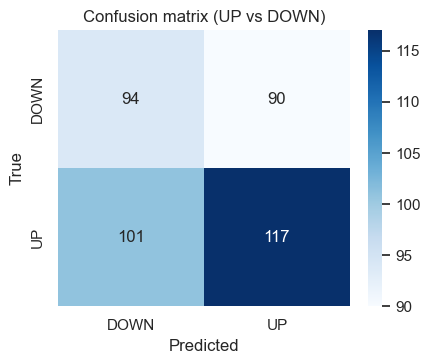


[CELL] Cell 25
Variables used in this cell:
  BINARY_TREND = False
  N_CLASSES = 3
  TWO_STAGE (two-stage XGB (move + direction) flag) = True
  XGBBaseline = <type XGBBaseline>
  X_test = ndarray shape=(448, 747) dtype=float64 sample=[ 81.33759015 191.25393206 108.91693976   5.9446794  202.14406513]
  X_test_dir = ndarray shape=(402, 747) dtype=float64 sample=[ 81.33759015 191.25393206 108.91693976   5.9446794  202.14406513]
  X_train = ndarray shape=(2087, 747) dtype=float64 sample=[214.6626803  269.08937111 185.82807396 140.12669116 232.90564605]
  X_train_dir = ndarray shape=(1238, 747) dtype=float64 sample=[217.05195401 270.31616172 192.76796227 139.5442375  248.81517194]
  X_val = ndarray shape=(447, 747) dtype=float64 sample=[ 42.23336471 141.55683756 155.81484544  29.61378872 136.16549112]
  X_val_dir = ndarray shape=(358, 747) dtype=float64 sample=[ 42.23336471 141.55683756 155.81484544  29.61378872 136.16549112]
  cm_title = 'Confusion matrix (3-class)'
  compute_sample_weigh

In [17]:

def print_ci(ci, key, name):
    if ci is None:
        return
    lo, hi = ci[key]
    print(f"  {name} 95% CI: [{lo:.4f}, {hi:.4f}]")


def print_basic_metrics(y_true, y_pred, lbls, names, title: str) -> None:
    print()
    print(title)

    metrics = calc_metrics(y_true, y_pred, lbls)
    print("Accuracy:", metrics["acc"])
    print("Balanced acc:", metrics["bal_acc"])
    print("MCC:", metrics["mcc"])
    print("F1 macro:", metrics["f1_macro"])
    print("Summary score (avg bal_acc + f1_macro):", metrics["summary"])

    counts = [int((y_true == lbl).sum()) for lbl in lbls]
    n = len(y_true)
    dist_parts = []
    for lbl, name, cnt in zip(lbls, names, counts):
        pct = 100.0 * cnt / n if n else 0.0
        dist_parts.append(f"{name}={cnt} ({pct:.1f}%)")
    print("Class distribution:", ", ".join(dist_parts))

    report_str = classification_report(
        y_true,
        y_pred,
        labels=lbls,
        target_names=names,
        zero_division=0,
    )
    report_dict = classification_report(
        y_true,
        y_pred,
        labels=lbls,
        target_names=names,
        output_dict=True,
        zero_division=0,
    )
    print("Classification report:")
    print(report_str)

    # Baseline 1: always predict majority class
    base_pred = majority_baseline_pred(y_true, lbls)
    base_metrics = calc_metrics(y_true, base_pred, lbls)
    print(
        f"Majority baseline -> acc={base_metrics['acc']:.4f}, "
        f"bal_acc={base_metrics['bal_acc']:.4f}, f1_macro={base_metrics['f1_macro']:.4f}, "
        f"summary={base_metrics['summary']:.4f}"
    )

    # Baseline 2: predict previous label (naive time baseline)
    prev_pred = prev_label_baseline_pred(y_true, fallback_label=lbls[0])
    prev_metrics = calc_metrics(y_true, prev_pred, lbls)
    print(
        f"Prev-label baseline -> acc={prev_metrics['acc']:.4f}, "
        f"bal_acc={prev_metrics['bal_acc']:.4f}, f1_macro={prev_metrics['f1_macro']:.4f}, "
        f"summary={prev_metrics['summary']:.4f}"
    )

    # Bootstrap CI for model metrics
    ci = bootstrap_metrics(y_true, y_pred, lbls, n_boot=200, seed=42)
    if ci is not None:
        print("Model 95% bootstrap CI:")
        print_ci(ci, "acc", "acc")
        print_ci(ci, "bal_acc", "bal_acc")
        print_ci(ci, "f1_macro", "f1_macro")
        print_ci(ci, "summary", "summary")

    # Sanity warnings
    warn_margin = 0.02
    if metrics["acc"] < max(base_metrics["acc"], prev_metrics["acc"]) + warn_margin:
        print("WARNING: accuracy barely above naive baselines")
    if metrics["bal_acc"] < max(base_metrics["bal_acc"], prev_metrics["bal_acc"]) + warn_margin:
        print("WARNING: balanced accuracy barely above naive baselines")
    if metrics["f1_macro"] < max(base_metrics["f1_macro"], prev_metrics["f1_macro"]) + warn_margin:
        print("WARNING: macro F1 barely above naive baselines")
    if metrics["summary"] < max(base_metrics["summary"], prev_metrics["summary"]) + warn_margin:
        print("WARNING: summary score barely above naive baselines")

    low_recall = []
    for name in names:
        if name in report_dict and report_dict[name]["recall"] < 0.2:
            low_recall.append(f"{name} (recall={report_dict[name]['recall']:.2f})")
    if low_recall:
        print("WARNING: low recall ->", ", ".join(low_recall))

    if len(counts) > 0 and min(counts) < 30:
        print("WARNING: some classes have <30 samples; metrics may be unstable")


def plot_confusion(y_true, y_pred, lbls, names, title: str) -> None:
    cm = confusion_matrix(y_true, y_pred, labels=lbls)
    plt.figure(figsize=(4.5, 3.8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=names,
        yticklabels=names,
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


if TWO_STAGE:
    print("Training mode: TWO_STAGE (MOVE/NO_MOVE -> UP/DOWN)")

    # --- Stage 1: MOVE vs NO_MOVE ---
    y_train_move = (y_train != 1).astype(np.int32)
    y_val_move = (y_val != 1).astype(np.int32)
    y_test_move = (y_test != 1).astype(np.int32)

    w_train_move = compute_sample_weight(class_weight="balanced", y=y_train_move)
    w_val_move = compute_sample_weight(class_weight="balanced", y=y_val_move)

    model_move = XGBBaseline(
        n_classes=2,
        device=device,
        random_state=42,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
    )

    model_move.fit(
        X_train, y_train_move,
        X_val=X_val, y_val=y_val_move,
        feature_names=feature_cols,
        sample_weight=w_train_move,
        sample_weight_val=w_val_move,
    )

    # --- Stage 2: direction (UP vs DOWN) only on MOVE rows ---
    mask_train_dir = y_train != 1
    mask_val_dir = y_val != 1
    mask_test_dir = y_test != 1

    X_train_dir = X_train[mask_train_dir]
    y_train_dir = (y_train[mask_train_dir] == 2).astype(np.int32)
    X_val_dir = X_val[mask_val_dir]
    y_val_dir = (y_val[mask_val_dir] == 2).astype(np.int32)

    w_train_dir = compute_sample_weight(class_weight="balanced", y=y_train_dir)
    w_val_dir = compute_sample_weight(class_weight="balanced", y=y_val_dir)

    model_dir = XGBBaseline(
        n_classes=2,
        device=device,
        random_state=42,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
    )

    model_dir.fit(
        X_train_dir, y_train_dir,
        X_val=X_val_dir, y_val=y_val_dir,
        feature_names=feature_cols,
        sample_weight=w_train_dir,
        sample_weight_val=w_val_dir,
    )

    # --- Combine predictions to preserve the original sequence ---
    move_pred = model_move.predict(X_test)
    dir_pred_full = model_dir.predict(X_test)

    # If MOVE then UP/DOWN else SIDEWAYS(1)
    y_pred = np.where(move_pred == 1, np.where(dir_pred_full == 1, 2, 0), 1)
else:
    if BINARY_TREND:
        print("Training mode: SINGLE_STAGE (binary)")
    else:
        print("Training mode: SINGLE_STAGE (3 classes)")

    w_train = compute_sample_weight(class_weight="balanced", y=y_train)
    w_val = compute_sample_weight(class_weight="balanced", y=y_val)

    model = XGBBaseline(
        n_classes=N_CLASSES,
        device=device,
        random_state=42,
        n_estimators=300,
        max_depth=3,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
    )

    model.fit(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        feature_names=feature_cols,
        sample_weight=w_train,
        sample_weight_val=w_val,
    )

    y_pred = model.predict(X_test)

# --- Metrics: overall 3-class ---
overall_title = "Overall (binary) metrics" if BINARY_TREND else "Overall (3-class) metrics"
print_basic_metrics(y_test, y_pred, label_ids, label_names, overall_title)
cm_title = "Confusion matrix (binary)" if BINARY_TREND else "Confusion matrix (3-class)"
plot_confusion(y_test, y_pred, label_ids, label_names, cm_title)

if TWO_STAGE:
    # Stage 1 metrics (MOVE vs NO_MOVE)
    move_names = ["NO_MOVE", "MOVE"]
    print_basic_metrics(y_test_move, move_pred, [0, 1], move_names, "Stage 1 (MOVE vs NO_MOVE) metrics")
    plot_confusion(y_test_move, move_pred, [0, 1], move_names, "Confusion matrix (MOVE vs NO_MOVE)")

    # Stage 2 metrics (UP vs DOWN) only on MOVE rows
    if mask_test_dir.sum() > 0:
        X_test_dir = X_test[mask_test_dir]
        y_test_dir = (y_test[mask_test_dir] == 2).astype(np.int32)
        dir_pred = model_dir.predict(X_test_dir)
        dir_names = ["DOWN", "UP"]
        print_basic_metrics(y_test_dir, dir_pred, [0, 1], dir_names, "Stage 2 (UP vs DOWN) metrics")
        plot_confusion(y_test_dir, dir_pred, [0, 1], dir_names, "Confusion matrix (UP vs DOWN)")
    else:
        print()
        print("Stage 2 metrics skipped: no MOVE samples in test set.")



trace_cell(
    title='Cell 25',
    used_vars=['BINARY_TREND', 'N_CLASSES', 'TWO_STAGE', 'XGBBaseline', 'X_test', 'X_test_dir', 'X_train', 'X_train_dir', 'X_val', 'X_val_dir', 'cm_title', 'compute_sample_weight', 'device', 'dir_names', 'dir_pred', 'dir_pred_full', 'feature_cols', 'label_ids', 'label_names', 'mask_test_dir', 'mask_train_dir', 'mask_val_dir', 'model', 'model_dir', 'model_move', 'move_names', 'move_pred', 'np', 'overall_title', 'plot_confusion', 'print_basic_metrics', 'w_train', 'w_train_dir', 'w_train_move', 'w_val', 'w_val_dir', 'w_val_move', 'y_pred', 'y_test', 'y_test_dir', 'y_test_move', 'y_train', 'y_train_dir', 'y_train_move', 'y_val', 'y_val_dir', 'y_val_move'],
    show_missing=False,
)


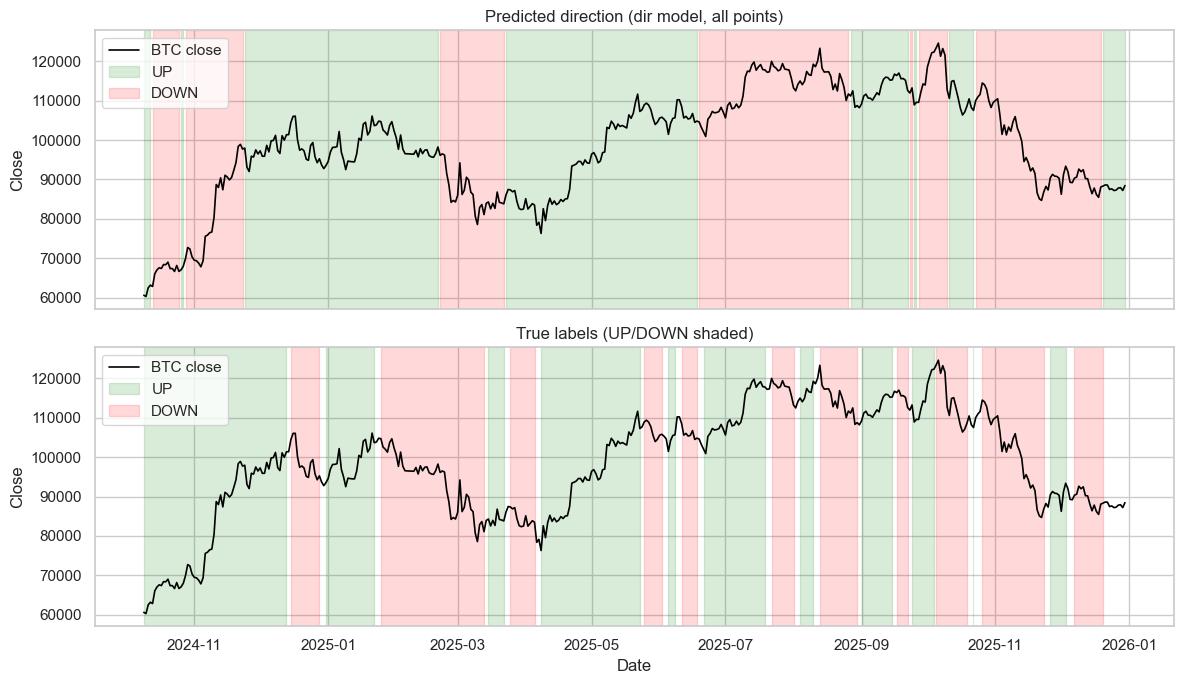


[CELL] Cell 26
Purpose: Plot BTC close with prediction background
Notes:
- Market dataframe is the price source for labels/plots.
Variables used in this cell:
  BINARY_TREND = False
  PLOT_END = None
  PLOT_LAST_N = 1400
  PLOT_PRICE_MODE = 'raw'
  PLOT_SCOPE = 'test'
  PLOT_START = None
  PRED_DIR_MASK_MOVE = False
  PRED_MODE = 'dir_only'
  PRICE_COL = 'close'
  SHOW_TRUE = True
  TWO_STAGE (two-stage XGB (move + direction) flag) = True
  X_plot = ndarray shape=(448, 747) dtype=float64 sample=[ 81.33759015 191.25393206 108.91693976   5.9446794  202.14406513]
  ax = <Axes: title={'center': 'Oracle labels (3-class: UP/DOWN shaded)'}, xlabel='Date', ylabel='Close'>
  axes = ndarray shape=(2,) dtype=object sample=[<Axes: title={'center': 'Predicted direction (dir model, all points)'}, ylabel='Close'>
 <Axes: title={'center': 'True labels (UP/DOWN shaded)'}, xlabel='Date', ylabel='Close'>]
  base_df = DataFrame shape=(448, 749) cols_count=749 cols_preview=['date', 'Jupiter_lon', 'Lilith_

In [18]:

# Plot BTC close with prediction background
# Green: UP, Red: DOWN, no color: SIDEWAYS

# --- Plot options ---
PLOT_SCOPE = "test"  # "test", "val", "train", "full"
PLOT_START = None    # e.g. "2023-01-01"
PLOT_END = None      # e.g. "2024-01-01"
PLOT_LAST_N = 1400    # set None to disable
PRED_MODE = "dir_only"  # "three_class" or "dir_only"
PRED_DIR_MASK_MOVE = False  # if True, show dir preds only when MOVE predicted
SHOW_TRUE = True           # second panel with true labels
PRICE_COL = "close"

# Select base dataframe
if PLOT_SCOPE == "full":
    base_df = df_dataset.copy()
elif PLOT_SCOPE == "train":
    base_df = train_df.copy()
elif PLOT_SCOPE == "val":
    base_df = val_df.copy()
else:
    base_df = test_df.copy()

if PLOT_SCOPE != "test":
    print("NOTE: PLOT_SCOPE is not test; this is in-sample visualization.")

base_df["date"] = pd.to_datetime(base_df["date"])

# Compute predictions for chosen scope
X_plot = base_df[feature_cols].to_numpy(dtype=np.float64)
if TWO_STAGE:
    move_pred_plot = model_move.predict(X_plot)
    dir_pred_plot = model_dir.predict(X_plot)
    pred_3c_plot = np.where(move_pred_plot == 1, np.where(dir_pred_plot == 1, 2, 0), 1)
else:
    move_pred_plot = np.full(len(base_df), np.nan)
    dir_pred_plot = np.full(len(base_df), np.nan)
    pred_3c_plot = model.predict(X_plot)

plot_df = base_df[["date", "target"]].copy()
plot_df["pred_3c"] = pred_3c_plot
plot_df["pred_move"] = move_pred_plot
plot_df["pred_dir"] = dir_pred_plot

market_dates = df_market[["date", PRICE_COL]].copy()
market_dates["date"] = pd.to_datetime(market_dates["date"])

plot_df = plot_df.merge(market_dates, on="date", how="left")
plot_df = plot_df.dropna(subset=[PRICE_COL]).sort_values("date").reset_index(drop=True)

# Apply date window
if PLOT_START is not None:
    plot_df = plot_df[plot_df["date"] >= pd.to_datetime(PLOT_START)]
if PLOT_END is not None:
    plot_df = plot_df[plot_df["date"] <= pd.to_datetime(PLOT_END)]
if PLOT_LAST_N is not None and len(plot_df) > PLOT_LAST_N:
    plot_df = plot_df.tail(PLOT_LAST_N)

if plot_df.empty:
    raise ValueError("Plot window is empty. Check PLOT_START/PLOT_END/PLOT_LAST_N")

# Helper to shade UP/DOWN zones

def shade_up_down(ax, dates, close, up_mask, down_mask, title: str, y_label: str):
    ax.plot(dates, close, color="black", linewidth=1.2, label="BTC close")
    ax.fill_between(
        dates,
        0,
        1,
        where=up_mask,
        transform=ax.get_xaxis_transform(),
        color="green",
        alpha=0.15,
        label="UP",
    )
    ax.fill_between(
        dates,
        0,
        1,
        where=down_mask,
        transform=ax.get_xaxis_transform(),
        color="red",
        alpha=0.15,
        label="DOWN",
    )
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.legend(loc="upper left")

# Choose prediction masks
preds_3c = plot_df["pred_3c"].to_numpy()
if BINARY_TREND:
    up_mask_pred = preds_3c == 1
    down_mask_pred = preds_3c == 0
    title_pred = "Predicted binary (UP/DOWN shaded)"
elif PRED_MODE == "dir_only" and TWO_STAGE:
    dir_pred = plot_df["pred_dir"].to_numpy().astype(int)
    if PRED_DIR_MASK_MOVE:
        move_mask = plot_df["pred_move"].to_numpy() == 1
        up_mask_pred = (dir_pred == 1) & move_mask
        down_mask_pred = (dir_pred == 0) & move_mask
        title_pred = "Predicted direction (dir model, MOVE only)"
    else:
        up_mask_pred = dir_pred == 1
        down_mask_pred = dir_pred == 0
        title_pred = "Predicted direction (dir model, all points)"
else:
    up_mask_pred = preds_3c == 2
    down_mask_pred = preds_3c == 0
    title_pred = "Predicted 3-class (UP/DOWN shaded)"

dates = plot_df["date"].to_numpy()
close = plot_df[PRICE_COL].to_numpy()
if PLOT_PRICE_MODE == 'log':
    close = np.log(close)
    y_label = 'log(price)'
else:
    y_label = 'Close'

if SHOW_TRUE:
    fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
    shade_up_down(axes[0], dates, close, up_mask_pred, down_mask_pred, title_pred, y_label)

    true_labels = plot_df["target"].to_numpy()
    if BINARY_TREND:
        up_mask_true = true_labels == 1
        down_mask_true = true_labels == 0
    else:
        up_mask_true = true_labels == 2
        down_mask_true = true_labels == 0
    shade_up_down(axes[1], dates, close, up_mask_true, down_mask_true, "True labels (UP/DOWN shaded)", y_label)

    axes[1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(12, 4))
    shade_up_down(ax, dates, close, up_mask_pred, down_mask_pred, title_pred, y_label)
    ax.set_xlabel("Date")
    plt.tight_layout()
    plt.show()





trace_cell(
    title='Cell 26',
    purpose='Plot BTC close with prediction background',
    used_vars=['BINARY_TREND', 'PLOT_END', 'PLOT_LAST_N', 'PLOT_PRICE_MODE', 'PLOT_SCOPE', 'PLOT_START', 'PRED_DIR_MASK_MOVE', 'PRED_MODE', 'PRICE_COL', 'SHOW_TRUE', 'TWO_STAGE', 'X_plot', 'ax', 'axes', 'base_df', 'close', 'dates', 'df_dataset', 'df_market', 'dir_pred', 'dir_pred_plot', 'down_mask_pred', 'down_mask_true', 'feature_cols', 'market_dates', 'model', 'model_dir', 'model_move', 'move_mask', 'move_pred_plot', 'np', 'pd', 'plot_df', 'plt', 'pred_3c_plot', 'preds_3c', 'shade_up_down', 'test_df', 'title_pred', 'train_df', 'true_labels', 'up_mask_pred', 'up_mask_true', 'val_df', 'y_label'],
    notes=['Market dataframe is the price source for labels/plots.'],
    show_missing=False,
)


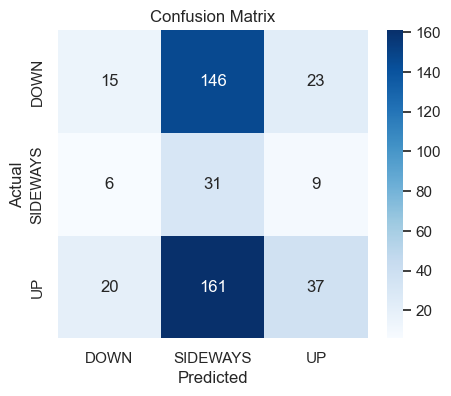


[CELL] Cell 27
Purpose: Confusion matrix
Variables used in this cell:
  BINARY_TREND = False
  cm = ndarray shape=(3, 3) dtype=int64 sample=[ 15 146  23   6  31]
  confusion_matrix = <function confusion_matrix>
  labels = list len=3 sample=['DOWN', 'SIDEWAYS', 'UP']
  lbl_ids = list len=3 sample=[0, 1, 2]
  plt = <module matplotlib.pyplot>
  sns = <module seaborn>
  y_pred = ndarray shape=(448,) dtype=int64 sample=[1 1 1 1 1]
  y_test = ndarray shape=(448,) dtype=int32 sample=[2 2 2 2 2]


In [19]:

# Confusion matrix
from sklearn.metrics import confusion_matrix

if BINARY_TREND:
    labels = ['DOWN', 'UP']
    lbl_ids = [0, 1]
else:
    labels = ['DOWN', 'SIDEWAYS', 'UP']
    lbl_ids = [0, 1, 2]

cm = confusion_matrix(y_test, y_pred, labels=lbl_ids)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




trace_cell(
    title='Cell 27',
    purpose='Confusion matrix',
    used_vars=['BINARY_TREND', 'cm', 'confusion_matrix', 'labels', 'lbl_ids', 'plt', 'sns', 'y_pred', 'y_test'],
    show_missing=False,
)


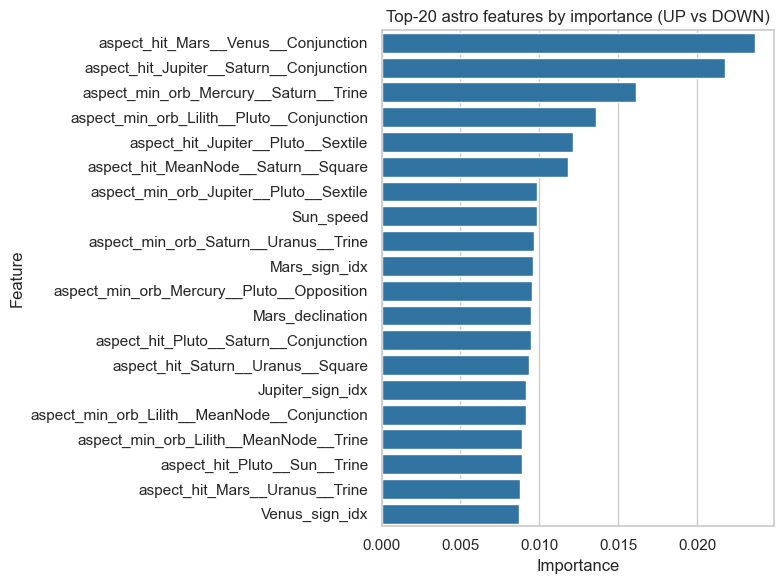


[CELL] Cell 28
Purpose: Feature importance (top 20)
Variables used in this cell:
  IMP_MODEL_STAGE = 'dir'
  TWO_STAGE (two-stage XGB (move + direction) flag) = True
  feature_cols (feature column names used for model training) = list len=747 sample=['Jupiter_lon', 'Lilith_lon', 'Mars_lon', 'MeanNode_lon', 'Mercury_lon']...
  imp_df = DataFrame shape=(747, 2) cols_count=2 cols_preview=['feature', 'importance'] head=
                                     feature  importance
219      aspect_hit_Mars__Venus__Conjunction    0.023670
96   aspect_hit_Jupiter__Saturn__Conjunction    0.021769
621    aspect_min_orb_Mercury__Saturn__Trine    0.016108
  importances = ndarray shape=(747,) dtype=float32 sample=[0.00589094 0.0050058  0.00837787 0.00492691 0.00533253]
  model_dir (two-stage direction model) = <src.models.xgb.XGBBaseline object at 0x000001B74ECA77D0>
  model_move (two-stage move model) = <src.models.xgb.XGBBaseline object at 0x000001B74CC06F90>
  pd = <module pandas>
  plt = <module m

In [20]:

# Feature importance (top 20)
# In two-stage mode you can plot one stage or both.
IMP_MODEL_STAGE = "dir"  # "dir", "move", or "both"

if TWO_STAGE:
    if IMP_MODEL_STAGE == "both":
        stage_models = [
            ("MOVE vs NO_MOVE", model_move),
            ("UP vs DOWN", model_dir),
        ]
    elif IMP_MODEL_STAGE == "move":
        stage_models = [("MOVE vs NO_MOVE", model_move)]
    else:
        stage_models = [("UP vs DOWN", model_dir)]
else:
    stage_models = [("3-class", model)]

for stage_name, stage_model in stage_models:
    importances = stage_model.model.feature_importances_
    imp_df = pd.DataFrame({
        "feature": feature_cols,
        "importance": importances,
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=imp_df.head(20), x="importance", y="feature", color="tab:blue")
    plt.title(f"Top-20 astro features by importance ({stage_name})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()





trace_cell(
    title='Cell 28',
    purpose='Feature importance (top 20)',
    used_vars=['IMP_MODEL_STAGE', 'TWO_STAGE', 'feature_cols', 'imp_df', 'importances', 'model', 'model_dir', 'model_move', 'pd', 'plt', 'sns', 'stage_model', 'stage_models', 'stage_name'],
    show_missing=False,
)


In [21]:

# Save model (optional)
from joblib import dump

artifact_dir = PROJECT_ROOT / "models_artifacts"
artifact_dir.mkdir(parents=True, exist_ok=True)

if TWO_STAGE:
    artifact = {
        "mode": "two_stage",
        "move": {
            "model": model_move.model,
            "scaler": model_move.scaler,
        },
        "dir": {
            "model": model_dir.model,
            "scaler": model_dir.scaler,
        },
        "feature_names": feature_cols,
        "config": {
            "sigma": SIGMA,
            "threshold": THRESHOLD,
            "horizon": HORIZON,
        },
    }
    out_path = artifact_dir / f"xgb_astro_baseline_two_stage_h{HORIZON}.joblib"
else:
    artifact = {
        "mode": "single_stage",
        "model": model.model,
        "scaler": model.scaler,
        "feature_names": feature_cols,
        "config": {
            "sigma": SIGMA,
            "threshold": THRESHOLD,
            "horizon": HORIZON,
        },
    }
    out_path = artifact_dir / f"xgb_astro_baseline_h{HORIZON}.joblib"

dump(artifact, out_path)
print(f"Saved: {out_path}")





trace_cell(
    title='Cell 29',
    purpose='Save model (optional)',
    used_vars=['HORIZON', 'PROJECT_ROOT', 'SIGMA', 'THRESHOLD', 'TWO_STAGE', 'artifact', 'artifact_dir', 'dump', 'feature_cols', 'model', 'model_dir', 'model_move', 'out_path'],
    show_missing=False,
)


Saved: C:\_PYTH\projects\PythonProject\ostrofun\models_artifacts\xgb_astro_baseline_two_stage_h1.joblib

[CELL] Cell 29
Purpose: Save model (optional)
Variables used in this cell:
  HORIZON = 1
  PROJECT_ROOT = Path('C:\_PYTH\projects\PythonProject\ostrofun')
  SIGMA = 5
  THRESHOLD = 53.58359714921031
  TWO_STAGE (two-stage XGB (move + direction) flag) = True
  artifact = dict keys_count=5 keys_preview=['mode', 'move', 'dir', 'feature_names', 'config']
  artifact_dir = Path('C:\_PYTH\projects\PythonProject\ostrofun\models_artifacts')
  dump = <function dump>
  feature_cols (feature column names used for model training) = list len=747 sample=['Jupiter_lon', 'Lilith_lon', 'Mars_lon', 'MeanNode_lon', 'Mercury_lon']...
  model_dir (two-stage direction model) = <src.models.xgb.XGBBaseline object at 0x000001B74ECA77D0>
  model_move (two-stage move model) = <src.models.xgb.XGBBaseline object at 0x000001B74CC06F90>
  out_path = Path('C:\_PYTH\projects\PythonProject\ostrofun\models_artifacts\x

## 8. Ideas for improvement

- Pick sigma/threshold based on model metrics, not only class balance.
- Add transit-to-natal aspects as extra features.
- Use separate models for different market regimes.


In [22]:





trace_cell(
    title='Cell 31',
    used_vars=[],
    show_missing=False,
)



[CELL] Cell 31
